In [1]:
import pandas as pd
import numpy as np
import re # for regular expressions
import nltk # for text manipulation
from nltk.stem.porter import *
from keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import CoherenceModel
from gensim import models
import os
import gensim.models.wrappers 

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")

C:\Users\jyoti\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
Train = pd.read_csv("Corona_NLP_train.csv")
Test = pd.read_csv("Corona_NLP_test.csv")

In [3]:
df=Test.append(Train, ignore_index=True)

In [4]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2/3/2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",3/3/2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
44950,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
44951,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
44952,44953,89905,NaN,14-04-2020,You know itÂ’s getting tough when @KameronWild...,Positive
44953,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [5]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Extremely Negative' 'Positive' 'Extremely Positive' 'Negative' 'Neutral']
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [6]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [7]:
import re
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [8]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [9]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [10]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [257]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

In [12]:
data=df.Tweet.values.tolist()

In [13]:
print(data[:1])

['TRENDING New Yorkers encounter empty supermarket shelves pictured Wegmans Brooklyn sold out online grocers FoodKick MaxDelivery #coronavirus fearing shoppers stock']


In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['trending', 'new', 'yorkers', 'encounter', 'empty', 'supermarket', 'shelves', 'pictured', 'wegmans', 'brooklyn', 'sold', 'out', 'online', 'grocers', 'foodkick', 'maxdelivery', 'coronavirus', 'fearing', 'shoppers', 'stock']]


In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['trending', 'new_yorkers', 'encounter', 'empty', 'supermarket', 'shelves', 'pictured', 'wegmans', 'brooklyn', 'sold', 'out', 'online', 'grocers', 'foodkick', 'maxdelivery', 'coronavirus', 'fearing', 'shoppers', 'stock']


In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [18]:
from gensim.utils import simple_preprocess
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['trend', 'new_yorker', 'encounter', 'empty', 'supermarket', 'shelf', 'picture', 'wegman', 'brooklyn', 'sell', 'online', 'grocer', 'foodkick', 'maxdelivery', 'coronavirus', 'fear', 'shopper', 'stock']]


In [19]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [20]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('brooklyn', 1),
  ('coronavirus', 1),
  ('empty', 1),
  ('encounter', 1),
  ('fear', 1),
  ('foodkick', 1),
  ('grocer', 1),
  ('maxdelivery', 1),
  ('new_yorker', 1),
  ('online', 1),
  ('picture', 1),
  ('sell', 1),
  ('shelf', 1),
  ('shopper', 1),
  ('stock', 1),
  ('supermarket', 1),
  ('trend', 1),
  ('wegman', 1)],
 [('coronavirus', 1),
  ('amazon', 1),
  ('check', 1),
  ('concern', 1),
  ('drive', 1),
  ('find', 1),
  ('pack', 1),
  ('price', 1),
  ('purell', 1),
  ('turn', 1)],
 [('coronavirus', 1), ('find', 1), ('protect', 1)],
 [('coronavirus', 1),
  ('shopper', 1),
  ('stock', 1),
  ('amp', 1),
  ('anxious', 1),
  ('become', 1),
  ('bigapple', 1),
  ('bloomberg', 1),
  ('buying', 1),
  ('city', 1),
  ('confirm', 1),
  ('event', 1),
  ('food', 1),
  ('healthcare', 1),
  ('hit', 1),
  ('medical', 1),
  ('newyork', 1),
  ('panic', 1),
  ('patient', 1),
  ('stage', 1),
  ('supply', 1),
  ('worker', 1)],
 [('coronavirus', 1),
  ('baby_milk', 1),
  ('buy', 2),
  ('corvid', 1),

### 4 Topics

In [21]:
lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, random_state=15, chunksize=100, passes=10, alpha='auto',
                                           per_word_topics=True)

In [22]:
# Print the Keyword in the 10 topics
print(lda_model1.print_topics())
doc_lda = lda_model1[corpus]

[(0, '0.039*"food" + 0.036*"amp" + 0.018*"need" + 0.017*"home" + 0.016*"help" + 0.013*"crisis" + 0.011*"keep" + 0.011*"stock" + 0.011*"take" + 0.010*"stay"'), (1, '0.023*"lockdown" + 0.022*"sanitizer" + 0.021*"mask" + 0.012*"die" + 0.011*"report" + 0.011*"use" + 0.010*"sale" + 0.009*"sell" + 0.009*"learn" + 0.008*"provide"'), (2, '0.070*"price" + 0.057*"consumer" + 0.030*"pandemic" + 0.025*"online" + 0.022*"demand" + 0.021*"oil" + 0.018*"shopping" + 0.014*"due" + 0.012*"impact" + 0.012*"change"'), (3, '0.093*"covid" + 0.047*"coronavirus" + 0.024*"store" + 0.021*"grocery" + 0.021*"supermarket" + 0.016*"people" + 0.015*"get" + 0.011*"time" + 0.010*"worker" + 0.009*"see"')]


In [23]:
# Compute Coherence Score
coherence_ldaModel1 = CoherenceModel(model=lda_model1, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldaModel1 = coherence_ldaModel1.get_coherence()
print('\nCoherence Score: ', coherence_ldaModel1)


Coherence Score:  0.3441689992399216


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_ldaModel1 = pyLDAvis.gensim_models.prepare(lda_model1, corpus, id2word)
vis_ldaModel1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.377682  0.052925       1        1  44.984852
0     -0.106131 -0.315364       2        1  24.384376
2     -0.195650  0.280080       3        1  18.912748
1     -0.075902 -0.017641       4        1  11.718024, topic_info=             Term          Freq         Total Category  logprob  loglift
51          covid  28636.000000  28636.000000  Default  30.0000  30.0000
24          price   9034.000000   9034.000000  Default  29.0000  29.0000
167      consumer   7341.000000   7341.000000  Default  28.0000  28.0000
1     coronavirus  14531.000000  14531.000000  Default  27.0000  27.0000
37           food   6551.000000   6551.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
936       current    482.462464    483.264604   Topic4  -5.1134   2.1424
759           key    461.628633    462.436830   Topic4  -5.1575   2.1423
202    restaurant    457.191399    457.997317   Topic4  -5.1672   2.1423
3572        india    397.865965    398.659564   Topic4  -5.3062   2.1420
970          move    389.481814    390.297473   Topic4  -5.3275   2.1420

[154 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
28        2  0.999848       amp
2978      3  0.997499     april
203       2  0.999213      bank
529       3  0.999184  behavior
521       3  0.999756  business
...     ...       ...       ...
1266      3  0.998659      wear
59        1  0.999828      week
477       1  0.999652      work
46        1  0.999632    worker
782       1  0.999212     world

[128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

### 6 Topics

In [25]:
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=6, random_state=15, chunksize=100, passes=10, alpha='auto',
                                           per_word_topics=True)

In [26]:
# Print the Keyword in the 10 topics
print(lda_model2.print_topics())
doc_lda2 = lda_model2[corpus]

[(0, '0.103*"covid" + 0.043*"price" + 0.039*"coronavirus" + 0.035*"consumer" + 0.019*"pandemic" + 0.012*"time" + 0.012*"need" + 0.011*"see" + 0.010*"help" + 0.010*"make"'), (1, '0.029*"bank" + 0.028*"die" + 0.024*"sale" + 0.021*"learn" + 0.019*"reduce" + 0.018*"financial" + 0.018*"shortage" + 0.017*"cause" + 0.017*"update" + 0.017*"agree"'), (2, '0.075*"online" + 0.055*"shopping" + 0.021*"behavior" + 0.016*"share" + 0.016*"month" + 0.014*"response" + 0.013*"wear" + 0.013*"shelf" + 0.013*"offer" + 0.012*"retailer"'), (3, '0.033*"demand" + 0.032*"oil" + 0.028*"worker" + 0.019*"impact" + 0.018*"change" + 0.016*"increase" + 0.013*"customer" + 0.013*"global" + 0.011*"retail" + 0.011*"employee"'), (4, '0.060*"food" + 0.055*"amp" + 0.027*"home" + 0.021*"due" + 0.018*"lockdown" + 0.017*"buy" + 0.017*"keep" + 0.017*"stock" + 0.016*"stay" + 0.014*"supply"'), (5, '0.055*"store" + 0.050*"grocery" + 0.050*"supermarket" + 0.037*"people" + 0.034*"get" + 0.028*"coronavirus" + 0.021*"work" + 0.020*"go"

In [27]:
# Compute Coherence Score
coherence_ldaModel2 = CoherenceModel(model=lda_model2, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldaModel2 = coherence_ldaModel2.get_coherence()
print('\nCoherence Score: ', coherence_ldaModel2)


Coherence Score:  0.2836012279788554


In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_ldaModel2 = pyLDAvis.gensim_models.prepare(lda_model2, corpus, id2word)
vis_ldaModel2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.364118  0.029064       1        1  37.864647
5     -0.143729 -0.040304       2        1  19.597104
4      0.135100 -0.312026       3        1  16.680811
3      0.146442  0.310383       4        1  14.012641
2      0.120579  0.008707       5        1   7.148158
1      0.105726  0.004176       6        1   4.696638, topic_info=          Term          Freq         Total Category  logprob  loglift
51       covid  26795.000000  26795.000000  Default  30.0000  30.0000
37        food   6871.000000   6871.000000  Default  29.0000  29.0000
159      store   7413.000000   7413.000000  Default  28.0000  28.0000
28         amp   6268.000000   6268.000000  Default  27.0000  27.0000
155    grocery   6684.000000   6684.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
897     profit    253.963695    254.838107   Topic6  -4.8408   3.0549
2728   partner    232.886759    233.759882   Topic6  -4.9274   3.0546
754   critical    229.444460    230.315802   Topic6  -4.9423   3.0545
1424   discuss    222.788655    223.661088   Topic6  -4.9718   3.0544
814       rate    218.496058    219.369586   Topic6  -4.9912   3.0543

[213 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4366      6  0.998236    agree
151       2  0.998483  alcohol
28        3  0.999938      amp
748       5  0.996711  article
917       2  0.998927      ask
...     ...       ...      ...
437       1  0.999410     well
477       2  0.999609     work
46        4  0.999610   worker
782       3  0.999621    world
783       3  0.999461     year

[184 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 5, 4, 3, 2])

### Optimal num of topics for LDA model

In [29]:
def compute_CV_ldaModels(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=15, chunksize=100,passes=10,
                                                alpha='auto', per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append (coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
# Can take a long time to run.
model_list1, coherence_values1 = compute_CV_ldaModels(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=13, step=2)

In [31]:
for i in range(6):
     coherence_values1[i]= round(coherence_values1[i], 4)

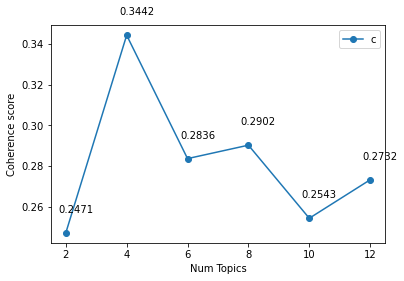

In [32]:
# Show graph
limit=13; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values1,'o-')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
for i, v in enumerate(coherence_values1):
    plt.text(x[i] - 0.25, v + 0.01, str(v))
    
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values1):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2471
Num Topics = 4  has Coherence Value of 0.3442
Num Topics = 6  has Coherence Value of 0.2836
Num Topics = 8  has Coherence Value of 0.2902
Num Topics = 10  has Coherence Value of 0.2543
Num Topics = 12  has Coherence Value of 0.2732


### LDA Mallet 4 Topics

In [34]:
mallet_path = 'C:/Mallet/bin/mallet' # update this path
ldamallet1 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word, random_seed=50)

In [35]:
# Show Topics
print(ldamallet1.show_topics(formatted=False))

# Compute Coherence Score
coherence_ldamallet1 = CoherenceModel(model=ldamallet1, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet1 = coherence_ldamallet1.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet1)

[(0, [('price', 0.058279191364895296), ('consumer', 0.03497010327957963), ('covid', 0.028168922941526675), ('pandemic', 0.021361271451867576), ('demand', 0.016501436595656564), ('due', 0.012981130121916496), ('crisis', 0.011460409494473637), ('oil', 0.011085082701317526), ('market', 0.009946160018636917), ('increase', 0.009137266067869437)]), (1, [('covid', 0.06912380901545277), ('food', 0.057280685366569696), ('coronavirus', 0.05486535536043129), ('amp', 0.02512076650030692), ('time', 0.02253863193573354), ('stock', 0.021404360938375725), ('panic', 0.020456911046465076), ('make', 0.01686727694894446), ('good', 0.013457791774533615), ('supply', 0.011249299420854572)]), (2, [('coronavirus', 0.061764915763319904), ('store', 0.06146650318847349), ('supermarket', 0.05403213773686498), ('grocery', 0.049049945182907444), ('people', 0.04156368189219521), ('day', 0.014135673925876911), ('covid', 0.011858656235201007), ('shelf', 0.01076231438413483), ('today', 0.01070392931514314), ('buy', 0.01

In [36]:
ldamallet1_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet1)

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_ldamallet1 = pyLDAvis.gensim_models.prepare(ldamallet1_model, corpus, id2word)
vis_ldamallet1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.325110 -0.250571       1        1  25.057246
3     -0.116196  0.356794       2        1  25.029499
2      0.314842 -0.141056       3        1  24.968513
1      0.126463  0.034833       4        1  24.944742, topic_info=            Term          Freq         Total Category  logprob  loglift
159        store  10503.000000  10503.000000  Default  30.0000  30.0000
1    coronavirus  19921.000000  19921.000000  Default  29.0000  29.0000
24         price   9994.000000   9994.000000  Default  28.0000  28.0000
37          food   9779.000000   9779.000000  Default  27.0000  27.0000
15   supermarket   9233.000000   9233.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
248        start    852.057063   1025.014532   Topic4  -5.3002   1.2037
684        great    763.206193    890.946023   Topic4  -5.4103   1.2338
207        local   1156.200426   1914.478020   Topic4  -4.9949   0.8842
108         shop   1198.347634   2666.124731   Topic4  -4.9591   0.5888
48           buy   1012.672098   2832.981760   Topic4  -5.1275   0.3598

[275 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
72        3  1.002931       age
180       2  0.884611   airsewa
18        2  0.999731    amazon
28        2  0.338426       amp
28        4  0.661582       amp
...     ...       ...       ...
101       3  1.003073   worried
775       4  0.997804     worth
377       2  1.105763  wrestler
783       1  1.000406      year
325       4  0.965663      yike

[276 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

### LDA Mallet 6 Topics

In [38]:
mallet_path = 'C:/Mallet/bin/mallet' # update this path
ldamallet2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word, random_seed=50)

In [39]:
# Show Topics
print(ldamallet2.show_topics(formatted=False))

# Compute Coherence Score
coherence_ldamallet2 = CoherenceModel(model=ldamallet2, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet2=coherence_ldamallet2.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet2)

[(0, [('store', 0.09281481118675614), ('grocery', 0.07406572953910956), ('work', 0.03127785668805407), ('worker', 0.02938727530979086), ('day', 0.021344957633344763), ('retail', 0.015457706812949992), ('covid', 0.014350786109614537), ('coronavirus', 0.012744281726012637), ('staff', 0.011696135573296762), ('employee', 0.01138267130332566)]), (1, [('food', 0.08466970432175473), ('people', 0.05985561275815137), ('covid', 0.03578120993352664), ('amp', 0.033108467956683825), ('stock', 0.031638952995246265), ('panic', 0.030238475649446712), ('buy', 0.024962029311399098), ('local', 0.016756415566996075), ('supply', 0.016608477819200346), ('coronavirus', 0.0156025011341894)]), (2, [('consumer', 0.05281724549025739), ('covid', 0.044120233744405574), ('pandemic', 0.0322571188461313), ('demand', 0.024918404440361953), ('business', 0.015908691148591867), ('due', 0.014100885336251881), ('impact', 0.012586237223210272), ('outbreak', 0.01214650067426271), ('product', 0.010954326030449314), ('change',

In [40]:
ldamallet2_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet2)

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_ldamallet2 = pyLDAvis.gensim_models.prepare(ldamallet2_model, corpus, id2word)
vis_ldamallet2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.319971 -0.215355       1        1  16.779547
1     -0.048635 -0.162290       2        1  16.745476
0     -0.196042 -0.155667       3        1  16.693996
2      0.233860  0.272721       4        1  16.650164
5     -0.098470  0.192676       5        1  16.588504
3     -0.210685  0.067915       6        1  16.542312, topic_info=            Term          Freq         Total Category  logprob  loglift
159        store  10604.000000  10604.000000  Default  30.0000  30.0000
24         price  10058.000000  10058.000000  Default  29.0000  29.0000
1    coronavirus  19885.000000  19885.000000  Default  28.0000  28.0000
37          food   9703.000000   9703.000000  Default  27.0000  27.0000
155      grocery   8462.000000   8462.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
156         make   1188.064972   2848.296459   Topic6  -4.5570   0.9249
330        today    709.709555   1850.193526   Topic6  -5.0722   0.8411
261         back    482.826028    762.732962   Topic6  -5.4574   1.3420
716        thing    557.708769   1403.914106   Topic6  -5.3132   0.8761
158         show    437.002262    755.484157   Topic6  -5.5571   1.2518

[403 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
875       5  1.001201     advice
193       4  1.005771   advisory
223       1  1.000659     affair
882       4  1.000293     affect
72        3  0.999279        age
...     ...       ...        ...
782       1  0.639509      world
782       4  0.360644      world
1089      2  0.999122      worry
783       1  0.999960       year
999       6  0.998637  yesterday

[448 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 6, 4])

___

### Finding optimal no. of topics

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=50, step=10):

    coherence_values = []
    model_list = []
    for num in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num, id2word=id2word, random_seed=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [43]:
# Can take a long time to run.
model_list2, coherence_values2 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=13, step=2)

In [44]:
for i in range(6):
     coherence_values2[i]= round(coherence_values2[i], 4)

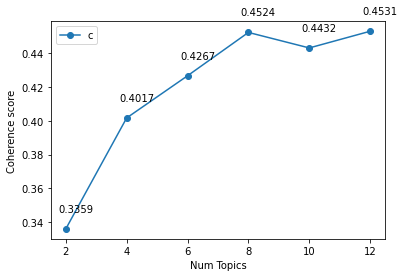

In [45]:
# Show graph
limit=13; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values2,'o-')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
for i, v in enumerate(coherence_values2):
    plt.text(x[i] - 0.25, v + 0.01, str(v))
plt.show()

In [46]:
# Print the coherence scores
for m, cv in zip(x, coherence_values2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3359
Num Topics = 4  has Coherence Value of 0.4017
Num Topics = 6  has Coherence Value of 0.4267
Num Topics = 8  has Coherence Value of 0.4524
Num Topics = 10  has Coherence Value of 0.4432
Num Topics = 12  has Coherence Value of 0.4531


In [52]:
from pprint import pprint
# Select the model and print the topics
optimal_model =  ldamallet2#model_list2[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.093*"store" + 0.074*"grocery" + 0.031*"work" + 0.029*"worker" + '
  '0.021*"day" + 0.015*"retail" + 0.014*"covid" + 0.013*"coronavirus" + '
  '0.012*"staff" + 0.011*"employee" + 0.011*"close" + 0.010*"today" + '
  '0.009*"hour" + 0.009*"put" + 0.009*"risk" + 0.008*"give" + 0.008*"open" + '
  '0.008*"line" + 0.008*"job" + 0.007*"care" + 0.007*"life" + '
  '0.007*"essential" + 0.007*"supermarket" + 0.006*"restaurant" + '
  '0.005*"elderly" + 0.005*"hard" + 0.005*"time" + 0.005*"die" + '
  '0.005*"shopper" + 0.005*"wait"'),
 (1,
  '0.085*"food" + 0.060*"people" + 0.036*"covid" + 0.033*"amp" + 0.032*"stock" '
  '+ 0.030*"panic" + 0.025*"buy" + 0.017*"local" + 0.017*"supply" + '
  '0.016*"coronavirus" + 0.015*"week" + 0.015*"buying" + 0.014*"stop" + '
  '0.013*"lockdown" + 0.011*"item" + 0.010*"leave" + 0.010*"family" + '
  '0.009*"bank" + 0.009*"run" + 0.007*"case" + 0.007*"coronacrisis" + '
  '0.007*"shortage" + 0.006*"thing" + 0.006*"community" + 0.006*"bad" + '
  '0.006*"lot" 

In [62]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [63]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.319971 -0.215355       1        1  16.779547
1     -0.048635 -0.162290       2        1  16.745476
0     -0.196042 -0.155667       3        1  16.693997
2      0.233860  0.272721       4        1  16.650164
5     -0.098470  0.192676       5        1  16.588504
3     -0.210685  0.067915       6        1  16.542312, topic_info=            Term          Freq         Total Category  logprob  loglift
159        store  10604.000000  10604.000000  Default  30.0000  30.0000
24         price  10058.000000  10058.000000  Default  29.0000  29.0000
1    coronavirus  19885.000000  19885.000000  Default  28.0000  28.0000
37          food   9703.000000   9703.000000  Default  27.0000  27.0000
155      grocery   8462.000000   8462.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
156         make   1188.064947   2848.296448   Topic6  -4.5570   0.9249
330        today    709.709540   1850.193543   Topic6  -5.0722   0.8411
261         back    482.826018    762.732960   Topic6  -5.4574   1.3420
716        thing    557.708757   1403.914092   Topic6  -5.3132   0.8761
158         show    437.002252    755.484142   Topic6  -5.5571   1.2518

[407 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
875       5  1.001201  advice
223       1  1.000659  affair
882       4  1.000293  affect
72        3  0.999279     age
334       4  0.997789   ahead
...     ...       ...     ...
782       1  0.639509   world
782       4  0.360644   world
1089      2  0.999122   worry
783       1  0.999960    year
325       2  0.973167    yike

[452 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 6, 4])

### Mapping Tweet to Cluster

In [64]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        wp = ldamodel.show_topic(row[0][0])
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(row[0][0]), round(row[0][1],4), topic_keywords]), ignore_index=True)
            
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.2075,"coronavirus, supermarket, covid, shelf, mask, ...",TRENDING New Yorkers encounter empty supermark...
1,1,3.0,0.2148,"coronavirus, supermarket, covid, shelf, mask, ...",When couldn find hand sanitizer Fred Meyer tur...
2,2,3.0,0.1866,"coronavirus, supermarket, covid, shelf, mask, ...",Find out how you can protect yourself and love...
3,3,1.0,0.2160,"food, people, covid, amp, stock, panic, buy, l...",#Panic buying hits #NewYork City anxious shopp...
4,4,3.0,0.2205,"coronavirus, supermarket, covid, shelf, mask, ...",#toiletpaper #dunnypaper #coronavirus #coronav...
...,...,...,...,...,...
44950,44950,3.0,0.1902,"coronavirus, supermarket, covid, shelf, mask, ...",Airline pilots offering stock supermarket shel...
44951,44951,2.0,0.2652,"consumer, covid, pandemic, demand, business, d...",Response complaint not provided citing COVID r...
44952,44952,3.0,0.2202,"coronavirus, supermarket, covid, shelf, mask, ...",You know getting tough when rationing toilet p...
44953,44953,3.0,0.1969,"coronavirus, supermarket, covid, shelf, mask, ...",wrong that the smell hand sanitizer starting t...


### Tweet in Each Topic

In [65]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3781,"store, grocery, work, worker, day, retail, cov...",Thank you doctors nurses hospital staff parame...
1,1.0,0.3531,"food, people, covid, amp, stock, panic, buy, l...",Seneca County Food Pantries Need Donations Now...
2,2.0,0.3873,"consumer, covid, pandemic, demand, business, d...",Our new ongoing study designed help clients an...
3,3.0,0.3789,"coronavirus, supermarket, covid, shelf, mask, ...",Corona virus safety tips Regularly and thoroug...
4,4.0,0.3994,"price, amp, oil, market, low, health, high, go...",kWh #wind and #solar #newyork state comparable...
5,5.0,0.3671,"covid, online, shopping, home, time, shop, cor...",Beware Scammers use fake emails texts get you ...


In [66]:
sent_topics_sorteddf_mallet.iloc[5]['Text']

'Beware Scammers use fake emails texts get you share valuable personal info like acct numbers SSNs your login IDs and passwords Here real world example phishers pretending Learn more about scams'

### Topic Distribution

In [67]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"store, grocery, work, worker, day, retail, cov...",8779,0.1953
1.0,1.0,"food, people, covid, amp, stock, panic, buy, l...",6907,0.1536
2.0,2.0,"consumer, covid, pandemic, demand, business, d...",7452,0.1658
3.0,3.0,"coronavirus, supermarket, covid, shelf, mask, ...",8241,0.1833
4.0,4.0,"price, amp, oil, market, low, health, high, go...",7356,0.1636
5.0,5.0,"covid, online, shopping, home, time, shop, cor...",6220,0.1384


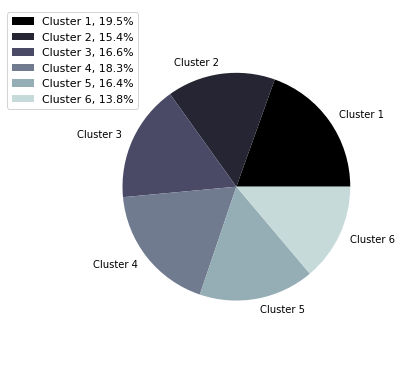

In [68]:
l=  ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']

fig1, ax1 = plt.subplots(figsize=(5, 5))
fig1.subplots_adjust(0.3, 0, 1, 1)

theme = plt.get_cmap('bone')
ax1.set_prop_cycle("color", [theme(1. * i / len(df_dominant_topics["Num_Documents"]))
                             for i in range(len(df_dominant_topics["Num_Documents"]))])

_, _ = ax1.pie(df_dominant_topics["Num_Documents"], labels = l, radius=700)
 
ax1.axis('equal')
 
total = sum(df_dominant_topics["Num_Documents"])
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100)
            for l, s in zip(l, df_dominant_topics["Num_Documents"])],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)
 
plt.show()

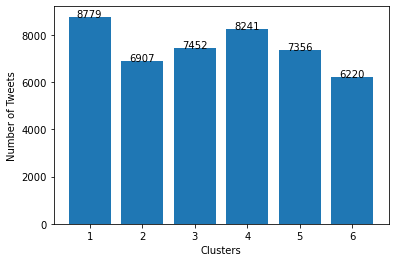

In [69]:
x=[1,2,3,4,5,6]
plt.bar(x, df_dominant_topics["Num_Documents"])
plt.xlabel('Clusters')
plt.ylabel('Number of Tweets')
for i, v in enumerate(df_dominant_topics["Num_Documents"]):
    plt.text(x[i] - 0.25, v + 0.01, str(v))
plt.show()

### Sentimental Analysis

### VADER Sentimental Analysis

In [70]:
cluster0= []
cluster1= []
cluster2= []
cluster3= []
cluster4= []
cluster5= []

In [71]:
for i in range(44955):
    if df_dominant_topic.iloc[i][1]==0:
        cluster0.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==1:
        cluster1.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==2:
        cluster2.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==3:
        cluster3.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==4:
        cluster4.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==5:
        cluster5.append(df_dominant_topic.iloc[i][4])

In [72]:
df_cluster0= pd.DataFrame(cluster0, columns=['Text'])
df_cluster1= pd.DataFrame(cluster1, columns=['Text'])
df_cluster2= pd.DataFrame(cluster2, columns=['Text'])
df_cluster3= pd.DataFrame(cluster3, columns=['Text'])
df_cluster4= pd.DataFrame(cluster4, columns=['Text'])
df_cluster5= pd.DataFrame(cluster5, columns=['Text'])

In [73]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [74]:
def sentiment_scores(sentence):
    sentiment = SentimentIntensityAnalyzer()
    return sentiment.polarity_scores(sentence)

In [75]:
df_cluster0['polarity'] = df_cluster0.Text.apply(sentiment_scores)
df_cluster1['polarity'] = df_cluster1.Text.apply(sentiment_scores)
df_cluster2['polarity'] = df_cluster2.Text.apply(sentiment_scores)
df_cluster3['polarity'] = df_cluster3.Text.apply(sentiment_scores)
df_cluster4['polarity'] = df_cluster4.Text.apply(sentiment_scores)
df_cluster5['polarity'] = df_cluster5.Text.apply(sentiment_scores)

In [76]:
df_cluster1

,Text,polarity
0,#Panic buying hits #NewYork City anxious shopp...,"{'neg': 0.194, 'neu': 0.806, 'pos': 0.0, 'comp..."
1,Panic food buying Germany due #coronavirus has...,"{'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compou..."
2,When you stockpiling food amp other supplies b...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,While you are stocking waiting for quarantine ...,"{'neg': 0.155, 'neu': 0.775, 'pos': 0.07, 'com..."
4,not due #Brexit all then Supermarkets begin #f...,"{'neg': 0.202, 'neu': 0.798, 'pos': 0.0, 'comp..."
...,...,...
6902,What changes are you seeing your local grocery...,"{'neg': 0.079, 'neu': 0.921, 'pos': 0.0, 'comp..."
6903,Will #coronavirus induced #recession make easi...,"{'neg': 0.192, 'neu': 0.616, 'pos': 0.192, 'co..."
6904,#PMModi addressed the nation amp extended lock...,"{'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'comp..."
6905,Singaporean politician who slammed woman snapp...,"{'neg': 0.19, 'neu': 0.81, 'pos': 0.0, 'compou..."


In [77]:
df_cluster0= pd.concat([df_cluster0.drop(['polarity'], axis=1), df_cluster0['polarity'].apply(pd.Series)], axis=1)
df_cluster1= pd.concat([df_cluster1.drop(['polarity'], axis=1), df_cluster1['polarity'].apply(pd.Series)], axis=1)
df_cluster2= pd.concat([df_cluster2.drop(['polarity'], axis=1), df_cluster2['polarity'].apply(pd.Series)], axis=1)
df_cluster3= pd.concat([df_cluster3.drop(['polarity'], axis=1), df_cluster3['polarity'].apply(pd.Series)], axis=1)
df_cluster4= pd.concat([df_cluster4.drop(['polarity'], axis=1), df_cluster4['polarity'].apply(pd.Series)], axis=1)
df_cluster5= pd.concat([df_cluster5.drop(['polarity'], axis=1), df_cluster5['polarity'].apply(pd.Series)], axis=1)

In [78]:
sa_C0= {'neg': df_cluster0['neg'].mean(), 'neu': df_cluster0['neu'].mean(), 'pos': df_cluster0['pos'].mean(), 'compound': df_cluster0['compound'].mean()}
sa_C1= {'neg': df_cluster1['neg'].mean(), 'neu': df_cluster1['neu'].mean(), 'pos': df_cluster1['pos'].mean(), 'compound': df_cluster1['compound'].mean()}
sa_C2= {'neg': df_cluster2['neg'].mean(), 'neu': df_cluster2['neu'].mean(), 'pos': df_cluster2['pos'].mean(), 'compound': df_cluster2['compound'].mean()}
sa_C3= {'neg': df_cluster3['neg'].mean(), 'neu': df_cluster3['neu'].mean(), 'pos': df_cluster3['pos'].mean(), 'compound': df_cluster3['compound'].mean()}
sa_C4= {'neg': df_cluster4['neg'].mean(), 'neu': df_cluster4['neu'].mean(), 'pos': df_cluster4['pos'].mean(), 'compound': df_cluster4['compound'].mean()}
sa_C5= {'neg': df_cluster5['neg'].mean(), 'neu': df_cluster5['neu'].mean(), 'pos': df_cluster5['pos'].mean(), 'compound': df_cluster5['compound'].mean()}

In [79]:
sa_C0_s= {'neg': df_cluster0['neg'].sum(), 'neu': df_cluster0['neu'].sum(), 'pos': df_cluster0['pos'].sum(), 'compound': df_cluster0['compound'].sum()}
sa_C1_s= {'neg': df_cluster1['neg'].sum(), 'neu': df_cluster1['neu'].sum(), 'pos': df_cluster1['pos'].sum(), 'compound': df_cluster1['compound'].sum()}
sa_C2_s= {'neg': df_cluster2['neg'].sum(), 'neu': df_cluster2['neu'].sum(), 'pos': df_cluster2['pos'].sum(), 'compound': df_cluster2['compound'].sum()}
sa_C3_s= {'neg': df_cluster3['neg'].sum(), 'neu': df_cluster3['neu'].sum(), 'pos': df_cluster3['pos'].sum(), 'compound': df_cluster3['compound'].sum()}
sa_C4_s= {'neg': df_cluster4['neg'].sum(), 'neu': df_cluster4['neu'].sum(), 'pos': df_cluster4['pos'].sum(), 'compound': df_cluster4['compound'].sum()}
sa_C5_s= {'neg': df_cluster5['neg'].sum(), 'neu': df_cluster5['neu'].sum(), 'pos': df_cluster5['pos'].sum(), 'compound': df_cluster5['compound'].sum()}

In [80]:
print(sa_C0)
print(sa_C1)
print(sa_C2)
print(sa_C3)
print(sa_C4)
print(sa_C5)

{'neg': 0.07436484793256637, 'neu': 0.791541975168014, 'pos': 0.11085567832327194, 'compound': 0.11304653149561512}
{'neg': 0.13256493412480055, 'neu': 0.7654838569567082, 'pos': 0.10194266685970768, 'compound': -0.08534705371362275}
{'neg': 0.07581427804616234, 'neu': 0.821665727321524, 'pos': 0.10251677402039755, 'compound': 0.08425220075147576}
{'neg': 0.08147203009343536, 'neu': 0.8091685475063644, 'pos': 0.10936051450066746, 'compound': 0.07432968086397293}
{'neg': 0.1210206634040243, 'neu': 0.7838949157150625, 'pos': 0.0950806144643824, 'compound': -0.06271722403480137}
{'neg': 0.0853832797427654, 'neu': 0.7827580385852049, 'pos': 0.13185080385852105, 'compound': 0.14304651125401918}


In [81]:
neg_score=[]
neg_score.append(sa_C0['neg'])
neg_score.append(sa_C1['neg'])
neg_score.append(sa_C2['neg'])
neg_score.append(sa_C3['neg'])
neg_score.append(sa_C4['neg'])
neg_score.append(sa_C5['neg'])

In [82]:
neg_score_s=[]
neg_score_s.append(sa_C0_s['neg'])
neg_score_s.append(sa_C1_s['neg'])
neg_score_s.append(sa_C2_s['neg'])
neg_score_s.append(sa_C3_s['neg'])
neg_score_s.append(sa_C4_s['neg'])
neg_score_s.append(sa_C5_s['neg'])

In [83]:
pos_score=[]
pos_score.append(sa_C0['pos'])
pos_score.append(sa_C1['pos'])
pos_score.append(sa_C2['pos'])
pos_score.append(sa_C3['pos'])
pos_score.append(sa_C4['pos'])
pos_score.append(sa_C5['pos'])

In [84]:
pos_score_s=[]
pos_score_s.append(sa_C0_s['pos'])
pos_score_s.append(sa_C1_s['pos'])
pos_score_s.append(sa_C2_s['pos'])
pos_score_s.append(sa_C3_s['pos'])
pos_score_s.append(sa_C4_s['pos'])
pos_score_s.append(sa_C5_s['pos'])

In [85]:
c_score=[]
c_score.append(sa_C0['compound'])
c_score.append(sa_C1['compound'])
c_score.append(sa_C2['compound'])
c_score.append(sa_C3['compound'])
c_score.append(sa_C4['compound'])
c_score.append(sa_C5['compound'])

In [86]:
for i in range(6):
    pos_score[i]= round(pos_score[i], 3)
    pos_score_s[i]= round(pos_score_s[i], 2)
    neg_score[i]= round(neg_score[i], 3)
    neg_score_s[i]= round(neg_score_s[i], 2)

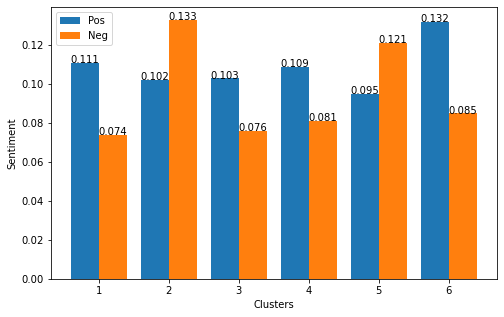

In [87]:
X=[1,2,3,4,5,6]

plt.figure(figsize=(8,5))
X_axis = np.arange(len(X))
w=0.4
plt.bar(X_axis-0.2, pos_score, w, label = 'Pos')
plt.bar(X_axis + 0.2, neg_score, w, label = 'Neg')
  
plt.xticks(X_axis, X)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.xlabel("Clusters")
plt.ylabel("Sentiment")

for i, v in enumerate(pos_score):
    plt.text(X[i] -w-1, v , str(v))
    
for i, v in enumerate(neg_score):
    plt.text(X[i] -1, v , str(v))

plt.legend()
plt.show()

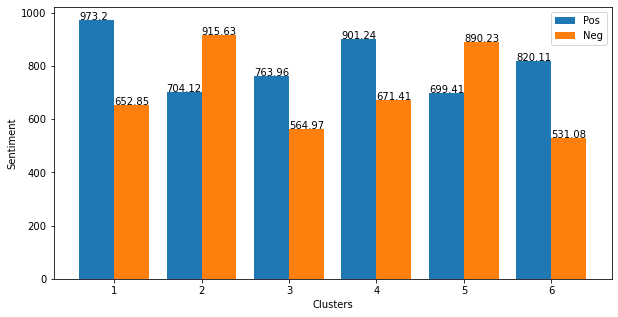

In [88]:
X=[1,2,3,4,5,6]

plt.figure(figsize=(10, 5))
X_axis = np.arange(len(X))
w=0.4
plt.bar(X_axis-0.2, pos_score_s, w, label = 'Pos')
plt.bar(X_axis + 0.2, neg_score_s, w, label = 'Neg')
  
plt.xticks(X_axis, X)
plt.xlabel("Clusters")
plt.ylabel("Sentiment")

for i, v in enumerate(pos_score_s):
    plt.text(X[i] -w-1, v , str(v))
    
for i, v in enumerate(neg_score_s):
    plt.text(X[i] -1, v , str(v))

plt.legend()
plt.show()

In [89]:
# num of tweets in each cluster
N=df_dominant_topics['Num_Documents']

In [90]:
def sentiments(c):
    if c>=0.05:
        return "Positive"
    elif c<=-0.05:
        return "Negative"
    else:
        return "Neutral"

In [104]:
s=[]
for i in range(N[4]):
    s.append(sentiments(df_cluster4.iloc[i]['compound']))
    
df_cluster4['Sentiment']=s

In [92]:
df_cluster5

,Text,neg,neu,pos,compound,Sentiment
0,Best quality couches unbelievably low prices a...,0.101,0.721,0.178,0.4228,Positive
1,Beware counterfeits trying sell fake masks che...,0.388,0.612,0.000,-0.8591,Negative
2,#AirSewa not providing #webchecin customers fr...,0.134,0.685,0.181,0.4019,Positive
3,What Precautionary measures have you all taken...,0.000,0.811,0.189,0.6808,Positive
4,Two important phone numbers NYers should know ...,0.091,0.859,0.050,-0.3612,Negative
...,...,...,...,...,...,...
6215,Are you feeling Rob,0.507,0.282,0.211,-0.4767,Negative
6216,Check out our website,0.000,1.000,0.000,0.0000,Neutral
6217,will begin put new grocery delivery customers ...,0.000,1.000,0.000,0.0000,Neutral
6218,IRS stimulus check portal When and how you can...,0.000,0.839,0.161,0.5574,Positive


### Alertness

In [93]:
import math

In [94]:
def count(df):
    pos=0
    neg=0
    for i in range(df.shape[0]):
        if df.iloc[i]['Sentiment']=='Positive':
            pos=pos+1
        elif df.iloc[i]['Sentiment']=='Negative':
            neg=neg+1
    pos_count.append(pos)
    neg_count.append(neg)
    

def alert(Sn, Nn, Sp, Np, N):
    Pn= Nn/N
    Pp= Np/N
    return (Pn*math.log2(Pn)*Sn*math.log10(Sn))/(Pp*math.log2(Pp)*Sp*math.log10(Sp))

In [95]:
pos_count=[]
neg_count=[]

In [105]:
count(df_cluster0)
count(df_cluster1)
count(df_cluster2)
count(df_cluster3)
count(df_cluster4)
count(df_cluster5)

In [106]:
alertness=[]
for i in range(6):
    alertness.append(alert(neg_score_s[i], neg_count[i], pos_score_s[i], pos_count[i],N[i]))

In [107]:
alertness

[0.6490075068260557,
 1.2749868160704765,
 0.7151270986057596,
 0.7202051555169681,
 1.2698958783622427,
 0.6503989377640289]

In [108]:
for i in range(6):
     alertness[i]= round(alertness[i], 4)

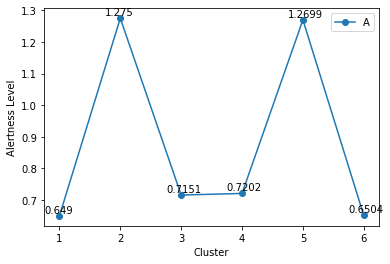

In [109]:
limit=7; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, alertness,'o-')
plt.xlabel("Cluster")
plt.ylabel("Alertness Level")
plt.legend(("Alertness level"), loc='best')
for i, v in enumerate(alertness):
    plt.text(x[i] - 0.25, v + 0.01, str(v))
plt.show()

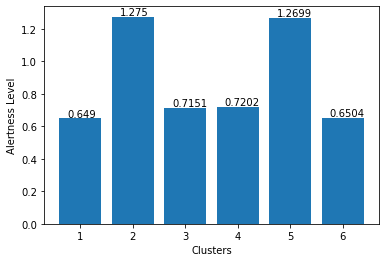

In [110]:
x=[1,2,3,4,5,6]
plt.bar(x, alertness)
plt.xlabel('Clusters')
plt.ylabel('Alertness Level')
for i, v in enumerate(alertness):
    plt.text(x[i] - 0.25, v + 0.01, str(v))
plt.show()

### Positive, Negative & Neutral words

In [258]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [259]:
tokenized_tweet= tokenized_tweet.to_frame()
tokenized_tweet=tokenized_tweet.values

In [260]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i][0] = ' '.join(tokenized_tweet[i][0])

In [261]:
df['Tweet']  = tokenized_tweet

In [262]:
pos=[]
neg=[]
neu=[]

for i in range(df.shape[0]):
    if df.iloc[i]['Sentiment']== 'Positive' or df.iloc[i]['Sentiment']== 'Extremely Positive':
        pos.append(df.iloc[i]['Tweet'])
        
    elif df.iloc[i]['Sentiment']== 'Negative' or df.iloc[i]['Sentiment']== 'Extremely Negative':
        neg.append(df.iloc[i]['Tweet'])
    
    else:
        neu.append(df.iloc[i]['Tweet'])

In [263]:
print(len(pos), len(neu), len(neg))

19592 8332 17031


In [264]:
from collections import Counter

In [265]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
neutral_counts = Counter()
total_counts = Counter()
 
for i in range(len(pos)):
    for word in pos[i].lower().split(" "):
        positive_counts[word]+=1
        total_counts[word]+=1
 
 
for i in range(len(neg)):
    for word in neg[i].lower().split(" "):
        negative_counts[word]+=1
        total_counts[word]+=1

        
for i in range(len(neu)):
    for word in neu[i].lower().split(" "):
        neutral_counts[word]+=1
        total_counts[word]+=1
        

In [266]:
pos_neg_ratios = Counter()
 
# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio


In [267]:
pos_neg_ratios

Counter({'the': 1.0759813639968279,
         'and': 1.220695618754804,
         '#coronaviru': 1.0917587085811384,
         'for': 1.3256912845642281,
         '#covid': 1.153684652529918,
         'are': 1.0652255639097745,
         'covid': 1.0910104840508588,
         'you': 1.5805263157894738,
         'store': 1.3891147951204255,
         'price': 0.7678257042253521,
         'thi': 1.1375,
         'food': 0.7728337236533958,
         'supermarket': 1.0740740740740742,
         'groceri': 1.3683385579937304,
         'that': 1.101192394456977,
         'have': 1.0909387222946545,
         'with': 1.1628542164561284,
         'peopl': 0.8297531260019237,
         'amp': 1.286859688195991,
         'from': 1.1793600721045516,
         'all': 1.2969330855018588,
         'shop': 1.471584699453552,
         'consum': 1.3674971687429218,
         'can': 1.3370332996972756,
         'your': 2.06986301369863,
         'not': 1.0157374100719425,
         'will': 1.1161542215714984,
     

In [268]:
pos_words=[]
neg_words=[]

In [269]:
for i in range(len(pos_neg_ratios.most_common())):
    if pos_neg_ratios.most_common()[i][1]>2.5:
        pos_words.append(pos_neg_ratios.most_common()[i][0])
    elif pos_neg_ratios.most_common()[i][1]<0.7:
        neg_words.append(pos_neg_ratios.most_common()[i][0])

In [270]:
len(pos_words)

88

In [271]:
len(neg_words)

173

### Count in clusters

In [272]:
cw=['#coronavirus', '#covid', 'covid']
def remove_cw(string):
    querywords = string.split()
    resultwords  = [word for word in querywords if word.lower() not in cw]
    result = ' '.join(resultwords)
    return result

In [273]:
C0_words = ' '.join([text for text in df_cluster0['Text']])
C0_words = remove_cw(C0_words)

C1_words = ' '.join([text for text in df_cluster1['Text']])
C1_words= remove_cw(C1_words)

C2_words = ' '.join([text for text in df_cluster2['Text']])
C2_words = remove_cw(C2_words)

C3_words = ' '.join([text for text in df_cluster3['Text']])
C3_words= remove_cw(C3_words)

C4_words = ' '.join([text for text in df_cluster4['Text']])
C4_words=remove_cw(C4_words)

C5_words = ' '.join([text for text in df_cluster5['Text']])
C5_words=remove_cw(C5_words)

In [274]:
def freq_w_pos(cluster):
    c=[]
    for i in range(len(pos_words)):
        c.append(cluster.count(pos_cluster1.iloc[i]['Words']))
    return c

In [275]:
def freq_w(cluster):
    c=[]
    for i in range(len(neg_words)):
        c.append(cluster.count(neg_cluster1.iloc[i]['Words']))
    return c

#### Positive

In [276]:
pos_cluster1=pd.DataFrame()
pos_cluster1['Words']= pos_words
pos_cluster2=pd.DataFrame()
pos_cluster2['Words']= pos_words
pos_cluster3=pd.DataFrame()
pos_cluster3['Words']= pos_words
pos_cluster4=pd.DataFrame()
pos_cluster4['Words']= pos_words
pos_cluster5=pd.DataFrame()
pos_cluster5['Words']= pos_words
pos_cluster6=pd.DataFrame()
pos_cluster6['Words']= pos_words

In [277]:
pos_cluster1['count']=freq_w_pos(C0_words)
pos_cluster2['count']=freq_w_pos(C1_words)
pos_cluster3['count']=freq_w_pos(C2_words)
pos_cluster4['count']=freq_w_pos(C3_words)
pos_cluster5['count']=freq_w_pos(C4_words)
pos_cluster6['count']=freq_w_pos(C5_words)

In [278]:
pos_cluster1= pos_cluster1.sort_values(by=['count'], ascending=False)
pos_cluster2= pos_cluster2.sort_values(by=['count'], ascending=False)
pos_cluster3= pos_cluster3.sort_values(by=['count'], ascending=False)
pos_cluster4= pos_cluster4.sort_values(by=['count'], ascending=False)
pos_cluster5= pos_cluster5.sort_values(by=['count'], ascending=False)
pos_cluster6= pos_cluster6.sort_values(by=['count'], ascending=False)

In [279]:
pos_cluster1

,Words,count
12,super,1746
46,ye,1424
44,care,664
30,help,495
81,sure,410
...,...,...
50,qualiti,1
71,chariti,1
38,pretti,0
20,safeti,0


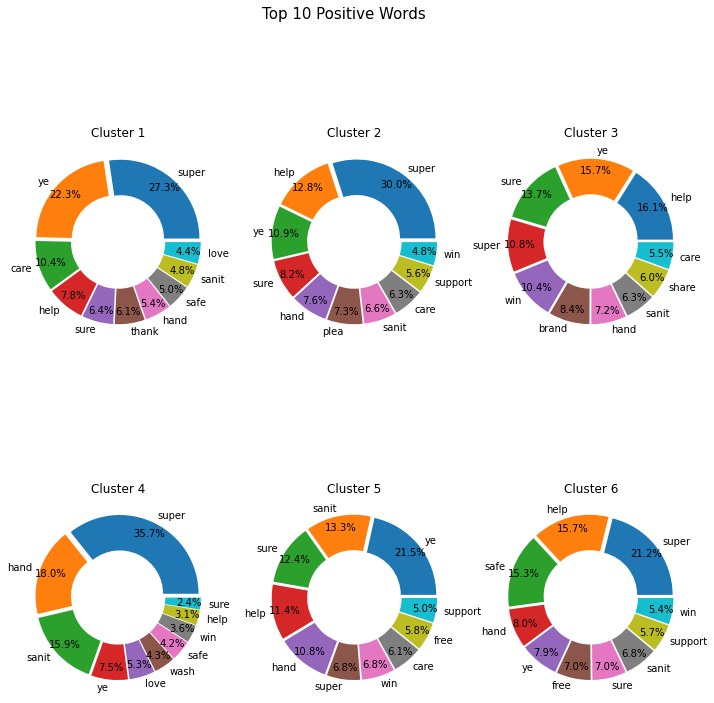

In [280]:
figure, axes = plt.subplots(2, 3, figsize=(12,12))
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

axes[0, 0].pie(pos_cluster1.iloc[0:10]["count"], labels = pos_cluster1.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85,wedgeprops=dict(width=.45))
axes[0, 0].set( title='Cluster 1')

axes[0, 1].pie(pos_cluster2.iloc[0:10]["count"], labels = pos_cluster2.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85, wedgeprops=dict(width=.45))
axes[0, 1].set( title='Cluster 2')

axes[0, 2].pie(pos_cluster3.iloc[0:10]["count"], labels = pos_cluster3.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85,wedgeprops=dict(width=.45))
axes[0, 2].set( title='Cluster 3')

axes[1, 0].pie(pos_cluster4.iloc[0:10]["count"], labels = pos_cluster4.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85, wedgeprops=dict(width=.45))
axes[1, 0].set( title='Cluster 4')

axes[1, 1].pie(pos_cluster5.iloc[0:10]["count"], labels = pos_cluster5.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85,wedgeprops=dict(width=.45))
axes[1, 1].set( title='Cluster 5')


axes[1, 2].pie(pos_cluster6.iloc[0:10]["count"], labels = pos_cluster6.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85, wedgeprops=dict(width=.45))
axes[1, 2].set( title='Cluster 6')

plt.suptitle("Top 10 Positive Words", fontsize=15)
plt.show()

#### Negative

In [281]:
neg_cluster1=pd.DataFrame()
neg_cluster1['Words']= neg_words
neg_cluster2=pd.DataFrame()
neg_cluster2['Words']= neg_words
neg_cluster3=pd.DataFrame()
neg_cluster3['Words']= neg_words
neg_cluster4=pd.DataFrame()
neg_cluster4['Words']= neg_words
neg_cluster5=pd.DataFrame()
neg_cluster5['Words']= neg_words
neg_cluster6=pd.DataFrame()
neg_cluster6['Words']= neg_words

In [282]:
neg_cluster1['count']=freq_w(C0_words)
neg_cluster2['count']=freq_w(C1_words)
neg_cluster3['count']=freq_w(C2_words)
neg_cluster4['count']=freq_w(C3_words)
neg_cluster5['count']=freq_w(C4_words)
neg_cluster6['count']=freq_w(C5_words)

In [283]:
neg_cluster1= neg_cluster1.sort_values(by=['count'], ascending=False)
neg_cluster2= neg_cluster2.sort_values(by=['count'], ascending=False)
neg_cluster3= neg_cluster3.sort_values(by=['count'], ascending=False)
neg_cluster4= neg_cluster4.sort_values(by=['count'], ascending=False)
neg_cluster5= neg_cluster5.sort_values(by=['count'], ascending=False)
neg_cluster6= neg_cluster6.sort_values(by=['count'], ascending=False)

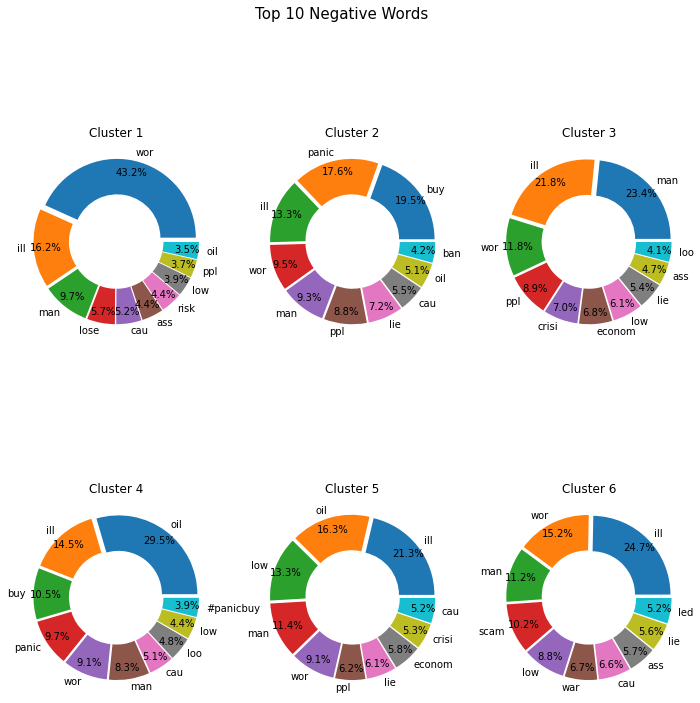

In [284]:
figure, axes = plt.subplots(2, 3, figsize=(12,12))
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

axes[0, 0].pie(neg_cluster1.iloc[0:10]["count"], labels = neg_cluster1.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85,wedgeprops=dict(width=.45))
axes[0, 0].set( title='Cluster 1')

axes[0, 1].pie(neg_cluster2.iloc[0:10]["count"], labels = neg_cluster2.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85, wedgeprops=dict(width=.45))
axes[0, 1].set( title='Cluster 2')

axes[0, 2].pie(neg_cluster3.iloc[0:10]["count"], labels = neg_cluster3.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85,wedgeprops=dict(width=.45))
axes[0, 2].set( title='Cluster 3')

axes[1, 0].pie(neg_cluster4.iloc[0:10]["count"], labels = neg_cluster4.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85, wedgeprops=dict(width=.45))
axes[1, 0].set( title='Cluster 4')

axes[1, 1].pie(neg_cluster5.iloc[0:10]["count"], labels = neg_cluster5.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85,wedgeprops=dict(width=.45))
axes[1, 1].set( title='Cluster 5')


axes[1, 2].pie(neg_cluster6.iloc[0:10]["count"], labels = neg_cluster6.iloc[0:10]['Words'], autopct= '%1.1f%%',explode=explode, pctdistance=0.85, wedgeprops=dict(width=.45))
axes[1, 2].set( title='Cluster 6')

plt.suptitle("Top 10 Negative Words", fontsize=15)
plt.show()